<a href="https://colab.research.google.com/github/codithj/stock_prediction_with_ml/blob/main/0531_test_quantile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Import

In [ ]:
import os
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import coint,adfuller,kpss
from scipy.stats import f
from scipy.stats import f_oneway
import torch.nn.functional as F
from statsmodels.stats.anova import anova_lm
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import pandas_datareader.data as pdr
import datetime
import math
import matplotlib.pyplot as plt

from torch.utils.data import Dataset,DataLoader

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import os
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt

In [ ]:
import random
random_seed= 827
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

# Data Load

In [ ]:
btc = pd.read_csv('/content/gdrive/Shareddrives/nlp paper writing/data/final/btc_usd.csv')
dow_rus_nas = pd.read_csv('/content/gdrive/Shareddrives/nlp paper writing/data/final/dow_russell_nasdaq_oil_interest.csv')
dow_rus_nas = dow_rus_nas.drop('Unnamed: 0',axis=1)
ftse = pd.read_csv('/content/gdrive/Shareddrives/nlp paper writing/data/final/ftse.csv')
index_bond = pd.read_csv('/content/gdrive/Shareddrives/nlp paper writing/data/final/index_bond.csv').close
index_eurodollar = pd.read_csv('/content/gdrive/Shareddrives/nlp paper writing/data/final/index_eurodollar.csv').close
index_gbpdollar = pd.read_csv('/content/gdrive/Shareddrives/nlp paper writing/data/final/index_gbpdollar.csv').close
index_gold=pd.read_csv('/content/gdrive/Shareddrives/nlp paper writing/data/final/index_gold.csv').close
index_silver =  pd.read_csv('/content/gdrive/Shareddrives/nlp paper writing/data/final/index_silver.csv').close
index_snp = pd.read_csv('/content/gdrive/Shareddrives/nlp paper writing/data/final/index_snp500.csv').close.str.replace(',', '')
index_snp = index_snp.str.replace('.','').astype(int)
n225 = pd.read_csv('/content/gdrive/Shareddrives/nlp paper writing/data/final/n225.csv')
jpy = pd.read_csv('/content/gdrive/Shareddrives/nlp paper writing/data/final/usd_jpy.csv')
train_mj = pd.read_csv('/content/gdrive/Shareddrives/nlp paper writing/data/final/train_set_mj.csv')

In [ ]:
train_mj2 = train_mj[['usd_jpy','btc_usd','ftse','n225']]
train_mj2

,usd_jpy,btc_usd,ftse,n225
0,105.556000,11573.299805,7116.000000,21042.089844
1,106.250000,10779.900391,7146.799805,21417.759766
2,105.537003,9965.570313,7157.799805,21252.720703
3,106.185997,9395.009766,7203.200195,21368.070313
4,106.405998,9337.549805,7224.500000,21469.199219
...,...,...,...,...
752,106.502998,49631.242188,6588.500000,29663.500000
753,106.850998,48378.988281,6613.799805,29408.169922
754,106.758003,50538.242188,6675.500000,29559.099609
755,107.057999,48561.167969,6650.899902,28930.109375


## Interpolate

In [ ]:
def interpolate(df):
    print('before:', df.isnull().sum())
    df = df.interpolate(method='linear')
    print('after:',df.isnull().sum())
    return df

# hj.lee: 여기에서 하는 것이 맞는지 확인 필요
print('DEBUG: index_snp = ', len(index_snp))
logReturns = index_snp[4:756].apply(np.log).diff().dropna()
print('DEBUG: index_snp =', index_snp)
print('DEBUG: logReturns = ', logReturns)


df_list = [index_snp, dow_rus_nas,index_bond,index_eurodollar,index_gbpdollar,index_gold,index_silver,train_mj2]

for i in range(len(df_list)):
    df_list[i] = interpolate(df_list[i]) 

DEBUG: index_snp =  757
DEBUG: index_snp = 0      272094
1      272812
2      272680
3      273897
4      278657
        ...  
752    390182
753    387029
754    381972
755    376847
756    384194
Name: close, Length: 757, dtype: int64
DEBUG: logReturns =  5     -0.001275
6     -0.006384
7     -0.005741
8     -0.000782
9      0.001702
         ...   
751   -0.004761
752    0.023512
753   -0.008114
754   -0.013152
755   -0.013508
Name: close, Length: 751, dtype: float64
before: 0
after: 0
before: russell2000          0
dow                  0
nasdaq               0
crude_oil            0
fed_fund_interest    0
dtype: int64
after: russell2000          0
dow                  0
nasdaq               0
crude_oil            0
fed_fund_interest    0
dtype: int64
before: 8
after: 0
before: 21
after: 0
before: 21
after: 0
before: 8
after: 0
before: 8
after: 0
before: usd_jpy    0
btc_usd    0
ftse       0
n225       0
dtype: int64
after: usd_jpy    0
btc_usd    0
ftse       0
n225       0
dtype: 

## Concat index

In [ ]:
res = pd.concat(df_list,axis=1)
res.columns = ['snp500','russell','dow','nasdaq','crude_oil','interest','bond','eurodollar','gpbdollar','gold','silver','jpy','btc','ftse','n225']
print(res.head(3))

   snp500      russell           dow  ...           btc         ftse          n225
0  272094  1546.050049  24874.759766  ...  11573.299805  7116.000000  21042.089844
1  272812  1562.199951  24884.119141  ...  10779.900391  7146.799805  21417.759766
2  272680  1574.530029  24801.359375  ...   9965.570313  7157.799805  21252.720703

[3 rows x 15 columns]


# Analysis for Stock Selection

## Correlation Matrix 
- Pearson 상관도 구하기

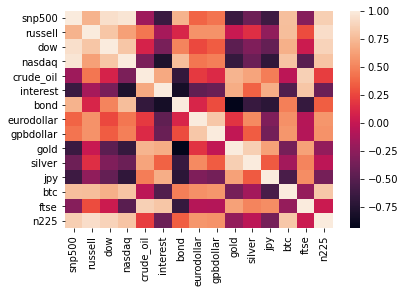

In [ ]:
sns.heatmap(res.corr())

In [ ]:
res.corr()

,snp500,russell,dow,nasdaq,crude_oil,interest,bond,eurodollar,gpbdollar,gold,silver,jpy,btc,ftse,n225
snp500,1.000000,0.716448,0.933772,0.962178,-0.182109,-0.640029,0.718655,0.367844,0.433821,-0.639182,-0.402025,-0.622402,0.778101,-0.285663,0.854798
russell,0.716448,1.000000,0.807427,0.627664,0.446655,-0.144200,0.101815,0.567200,0.562972,0.017627,0.147873,-0.241747,0.768477,0.278334,0.925319
dow,0.933772,0.807427,1.000000,0.810067,0.087316,-0.342957,0.503604,0.258973,0.340253,-0.472369,-0.318519,-0.439697,0.697152,0.029996,0.873567
nasdaq,0.962178,0.627664,0.810067,1.000000,-0.330850,-0.787438,0.772002,0.440471,0.484101,-0.662763,-0.406611,-0.692219,0.798058,-0.488185,0.798993
crude_oil,-0.182109,0.446655,0.087316,-0.330850,1.000000,0.671674,-0.677437,0.197910,0.125077,0.722869,0.647441,0.470445,-0.043727,0.858488,0.213187
interest,-0.640029,-0.144200,-0.342957,-0.787438,0.671674,1.000000,-0.826844,-0.462619,-0.412633,0.684259,0.361334,0.691206,-0.525103,0.803477,-0.405749
bond,0.718655,0.101815,0.503604,0.772002,-0.677437,-0.826844,1.000000,0.105136,0.279379,-0.940436,-0.653886,-0.717584,0.477492,-0.665340,0.347883
eurodollar,0.367844,0.567200,0.258973,0.440471,0.197910,-0.462619,0.105136,1.000000,0.815092,0.170071,0.525103,-0.317108,0.558567,-0.075020,0.581132
gpbdollar,0.433821,0.562972,0.340253,0.484101,0.125077,-0.412633,0.279379,0.815092,1.000000,-0.022396,0.337431,-0.369700,0.581611,-0.083264,0.564733
gold,-0.639182,0.017627,-0.472369,-0.662763,0.722869,0.684259,-0.940436,0.170071,-0.022396,1.000000,0.851956,0.632105,-0.350681,0.636074,-0.220518


## ADF-test

- 단위근 검정 중 가장 대표적인 방법으로 ADF 테스트를 사용  
- 시계열 데이터가 안정적stationary인지 여부 확인  
  
- 귀무가설: 데이터에 단위근 존재
- 대립가설: 데이터가 안정적  
  
- 기준: p-value < 0.05인 경우, 귀무가설 기각 -> 대립가설 채택

- NaN: bond ,eurodollar ,gpbdollar ,gold ,silver

In [ ]:
import numpy as np
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.tsatools import lagmat, add_trend
from statsmodels.tsa.adfvalues import mackinnonp

def adf(ts):
    """
    Augmented Dickey-Fuller unit root test
    """
    # make sure we are working with an array, convert if necessary
    ts = np.asarray(ts)
    
    # Get the dimension of the array
    nobs = ts.shape[0]
    
    # We use 1 as maximum lag in our calculations
    maxlag = 1
    
    # Calculate the discrete difference
    tsdiff = np.diff(ts)
    
    # Create a 2d array of lags, trim invalid observations on both sides
    tsdall = lagmat(tsdiff[:, None], maxlag, trim='both', original='in')
    # Get dimension of the array
    nobs = tsdall.shape[0] 
    
    # replace 0 xdiff with level of x
    tsdall[:, 0] = ts[-nobs - 1:-1]  
    tsdshort = tsdiff[-nobs:]
    
    # Calculate the linear regression using an ordinary least squares model    
    results = OLS(tsdshort, add_trend(tsdall[:, :maxlag + 1], 'c')).fit()
    adfstat = results.tvalues[0]
    
    # Get approx p-value from a precomputed table (from stattools)
    pvalue = mackinnonp(adfstat, 'c', N=1)
    return pvalue

- 위에서 정의한 adf 함수를 이용하여 각 설명 변수인 주가에 대한 안정성 여부를 테스트해보자.

In [ ]:
rlist = list(res.columns)
for s in rlist:
    if adf(res[s]) < 0.05:
        print(f'{s} p-value: {adf(res[s])} =====> stationary')
    else:
        print(f'{s} p-value: {adf(res[s])} =====> non-stationary')

snp500 p-value: 0.9142313343011532 =====> non-stationary
russell p-value: 0.9541777344527317 =====> non-stationary
dow p-value: 0.6359101439916552 =====> non-stationary
nasdaq p-value: 0.9793205885859251 =====> non-stationary
crude_oil p-value: 0.24001705546273594 =====> non-stationary
interest p-value: 0.964518363866872 =====> non-stationary
bond p-value: 0.9172227851186396 =====> non-stationary
eurodollar p-value: 0.6270836116389749 =====> non-stationary
gpbdollar p-value: 0.1560630070917176 =====> non-stationary
gold p-value: 0.7882997553131568 =====> non-stationary
silver p-value: 0.3369253307347426 =====> non-stationary
jpy p-value: 0.10724557406996937 =====> non-stationary
btc p-value: 1.0 =====> non-stationary
ftse p-value: 0.42502457193778376 =====> non-stationary
n225 p-value: 0.910886870510428 =====> non-stationary


In [ ]:
import statsmodels.tsa.stattools as ts 

for i in range(15):
    try:
        _,p,_ = ts.coint(res.snp500,res[res.columns[i]])
        #print(tmp)
        print(res.columns[i],':',round(p,3))
    except:
        print(res.columns[i],':','NAN')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1432: CollinearityWarning:

y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.



snp500 : 0.0
russell : 0.864
dow : 0.594
nasdaq : 0.103
crude_oil : 0.867
interest : 0.219
bond : 0.468
eurodollar : 0.722
gpbdollar : 0.546
gold : 0.681
silver : 0.793
jpy : 0.25
btc : 0.219
ftse : 0.585
n225 : 0.727


# Preprocessing

In [ ]:
res.snp500 /= 100000
res.russell /= 1000
res.dow /= 10000
res.nasdaq /= 1000
res.crude_oil /= 10
res.gold /= 1000
res.silver /= 10
res.jpy /= 100
res.btc /= 10000
res.ftse /= 1000
res.n225 /= 10000
res

,snp500,russell,dow,nasdaq,crude_oil,interest,bond,eurodollar,gpbdollar,gold,silver,jpy,btc,ftse,n225
0,2.72094,1.54605,2.487476,7.33071,6.257,1.42,1.554,1.196774,1.389410,1.6980,2.5257,1.05556,1.157330,7.1160,2.104209
1,2.72812,1.56220,2.488412,7.37201,6.260,1.42,1.550,1.205066,1.392699,1.7002,2.5434,1.06250,1.077990,7.1468,2.141776
2,2.72680,1.57453,2.480136,7.39665,6.115,1.42,1.470,1.208547,1.395498,1.7153,2.6357,1.05537,0.996557,7.1578,2.125272
3,2.73897,1.57197,2.489521,7.42795,6.012,1.42,1.415,1.205110,1.392952,1.7331,2.6850,1.06186,0.939501,7.2032,2.136807
4,2.78657,1.59714,2.533574,7.56081,6.204,1.42,1.446,1.208956,1.397253,1.7225,2.6647,1.06406,0.933755,7.2245,2.146920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,3.90182,2.27532,3.153551,13.58883,6.064,0.07,2.894,1.230663,1.380567,1.3224,1.6546,1.06503,4.963124,6.5885,2.966350
753,3.87029,2.23151,3.139152,13.35879,5.975,0.07,2.866,1.241465,1.390627,1.3199,1.6436,1.06851,4.837899,6.6138,2.940817
754,3.81972,2.20779,3.127009,12.99775,6.128,0.07,2.883,1.241665,1.390009,1.3260,1.6428,1.06758,5.053824,6.6755,2.955910
755,3.76847,2.14692,3.092414,12.72347,6.383,0.07,2.877,1.233654,1.385233,1.3336,1.6715,1.07058,4.856117,6.6509,2.893011


# Dataset

In [ ]:
def sliding_window(data,seq_len):
    x = []
    y = []

    for i in range(len(data) - seq_len - 1):
        _x = data[i:(i+seq_len)] # 5일 동안의 데이터로
        _y = data[i+seq_len] # 다음 날을 예측
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

In [ ]:
def coint_cal(df1,df2):

    df1 = np.array(df1)
    df2 = np.array(df2)
    df_1 = np.log(df1)
    df_2 = np.log(df2)

    t,p,crit = coint(df1,df2)

    if p <0.05:
        return p,'Cointgrated'
    else:
        return p,'Not Cointegrated'

In [ ]:
reslist = list(res.columns)
valuelst=[]
for z in reslist:
    vres = coint_cal(res.snp500.cumsum(),res[z].cumsum())
    print(f'{z}: {vres[0]} ====> {vres[1]}')
    valuelst.append(vres[0])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1432: CollinearityWarning:

y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.



snp500: 0.0 ====> Cointgrated
russell: 0.0502915182738702 ====> Not Cointegrated
dow: 0.5963804925069988 ====> Not Cointegrated
nasdaq: 0.30407794411208516 ====> Not Cointegrated
crude_oil: 0.5087224819932542 ====> Not Cointegrated
interest: 0.21957263967257518 ====> Not Cointegrated
bond: 0.07978749798258261 ====> Not Cointegrated
eurodollar: 0.965290400888615 ====> Not Cointegrated
gpbdollar: 0.9831429859786913 ====> Not Cointegrated
gold: 0.876986296457154 ====> Not Cointegrated
silver: 0.9688949712190824 ====> Not Cointegrated
jpy: 0.9374166177230707 ====> Not Cointegrated
btc: 0.9108658733325552 ====> Not Cointegrated
ftse: 0.6329456256461752 ====> Not Cointegrated
n225: 0.2303411037876521 ====> Not Cointegrated


In [ ]:
sorted(valuelst,reverse=True) #crudeoil, russell2000, silver, n225,eurodollar, dow, ftse, gpbdollar, bond, jpy, btc,interest, nasdaq

[0.9831429859786913,
 0.9688949712190824,
 0.965290400888615,
 0.9374166177230707,
 0.9108658733325552,
 0.876986296457154,
 0.6329456256461752,
 0.5963804925069988,
 0.5087224819932542,
 0.30407794411208516,
 0.2303411037876521,
 0.21957263967257518,
 0.07978749798258261,
 0.0502915182738702,
 0.0]

In [ ]:
scaler = MinMaxScaler()


# t1 = scaler.fit_transform(res.snp500.values.reshape(-1,1))
# t2 = scaler.fit_transform(res.russell.values.reshape(-1,1))
# t3 = scaler.fit_transform(res.dow.values.reshape(-1,1))
# t4 = scaler.fit_transform(res.nasdaq.values.reshape(-1,1))
# t5 = scaler.fit_transform(res.crude_oil.values.reshape(-1,1))
# t6 = scaler.fit_transform(res.interest.values.reshape(-1,1))
# t7 = scaler.fit_transform(res.bond.values.reshape(-1,1))
# t8 = scaler.fit_transform(res.eurodollar.values.reshape(-1,1))
# t9 = scaler.fit_transform(res.gpbdollar.values.reshape(-1,1))
# t10 = scaler.fit_transform(res.gold.values.reshape(-1,1))
# t11 = scaler.fit_transform(res.silver.values.reshape(-1,1))
# t12 = scaler.fit_transform(res.jpy.values.reshape(-1,1))
# t13 = scaler.fit_transform(res.btc.values.reshape(-1,1))
# t14 = scaler.fit_transform(res.ftse.values.reshape(-1,1))
# t15 = scaler.fit_transform(res.n225.values.reshape(-1,1))

# data_list = [t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15]
# train_data = np.concatenate(data_list,axis=1) ## 결측치가 없고 len이 모두 동일한 것만 일단 pick

"""
공적분 검정으로 추출
"""
t1 = scaler.fit_transform(res.snp500.values.reshape(-1,1))
t2 = scaler.fit_transform(res.interest.values.reshape(-1,1))
t3 = scaler.fit_transform(res.btc.values.reshape(-1,1))
t4 = scaler.fit_transform(res.nasdaq.values.reshape(-1,1))
t5 = scaler.fit_transform(res.bond.values.reshape(-1,1))

data_list= [t1,t2,t3,t4]
train_data = np.concatenate(data_list,axis=1)

"""
correlation matrix로 추출 dow,nasd,n225,btc
"""

# t1 = scaler.fit_transform(res.snp500.values.reshape(-1,1))
# t2 = scaler.fit_transform(res.dow.values.reshape(-1,1))
# t3 = scaler.fit_transform(res.nasdaq.values.reshape(-1,1))
# t4 = scaler.fit_transform(res.n225.values.reshape(-1,1))
# t5 = scaler.fit_transform(res.btc.values.reshape(-1,1))


# data_list= [t1,t2,t3,t4,t5]
# train_data = np.concatenate(data_list,axis=1)




seq_len = 5

x,y = sliding_window(train_data, seq_len)

train_size = int(len(y)*0.8+1) # int화 과정에서 총 데이터 개수 5496 에서 1 가 빠지길래, 그 빠진 1를 train_set에 넣어주었다.
test_size = len(y)-train_size

val_size = test_size // 2
test_size = test_size - val_size


"""
autograd.Variable은 autograd 패키지의 핵심 클래스입니다. 
Variable 클래스는 Tensor를 감싸고 있으며, Tensor에 정의된 거의 모든 연산을 지원합니다. 
모든 계산을 마친 후에 .backward()를 호출하면, 자동으로 모든 기울기가 계산됩니다.

cf: http://taewan.kim/trans/pytorch/tutorial/blits/02_autograd/
"""
dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
valX = Variable(torch.Tensor(np.array(x[train_size:train_size+val_size])))
testX = Variable(torch.Tensor(np.array(x[train_size+val_size:len(x)])))

trainY = Variable(torch.Tensor(np.array(y[0:train_size])))
valY = Variable(torch.Tensor(np.array(y[train_size:train_size+val_size])))
testY = Variable(torch.Tensor(np.array(y[train_size+val_size:len(y)])))


print(trainX.shape)
print(valX.shape)
print(testX.shape)

print(trainY.shape)
print(valY.shape)
print(testY.shape)

torch.Size([601, 5, 4])
torch.Size([75, 5, 4])
torch.Size([75, 5, 4])
torch.Size([601, 4])
torch.Size([75, 4])
torch.Size([75, 4])


In [ ]:
class customDataset(Dataset): 
    def __init__(self,dataX,dataY):
        self.x_data = dataX
        self.y_data = dataY

    def __len__(self): 
        return self.x_data.size()[0]

    def __getitem__(self, idx): 
        x = torch.FloatTensor(self.x_data[idx])
        y = torch.FloatTensor(self.y_data[idx])
        return x, y



train_set = customDataset(trainX,trainY)
val_set = customDataset(valX,valY)
test_set = customDataset(testX,testY)

train_dataloader = DataLoader(train_set,batch_size=len(trainX))
val_dataloader = DataLoader(val_set,batch_size=len(valX))
test_dataloader = DataLoader(test_set,batch_size=len(testX))

# LSTM

## Use Cuda

In [ ]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print(f'device:{DEVICE}')

device:cuda


## Args

In [ ]:
import argparse

parser = argparse.ArgumentParser(description= 'hyper-parameters')
args = parser.parse_args("")


args.EPOCHS = 1000
args.LR = 3e-3

args.INPUT_SIZE = len(data_list)
args.HIDDEN_SIZE = 64

args.NUM_LAYERS = 1
args.NUM_CLASSES = 1
args.dropout_p = 0.3

## Model

### LSTM

In [ ]:
class LSTM(nn.Module):
    def __init__(self,num_classes,input_size,hid_size,num_layers):
        super(LSTM,self).__init__()

        self.input_size = input_size
        self.hid_size = hid_size
        self.num_classes = num_classes
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size=input_size, hidden_size= hid_size, num_layers = num_layers, batch_first = True)
        self.fc = nn.Linear(hid_size,num_classes)

    def forward(self,x):

        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hid_size)).to(DEVICE)
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hid_size)).to(DEVICE)

        out, (hout, _) = self.lstm(x,(h_0,c_0))
        hout = hout.view(-1,self.hid_size).to(DEVICE)
        out = self.fc(hout).to(DEVICE)

        return out

    def init_hidden(self, batch):
        return (autograd.Variable(torch.zeros(1, 1, self.hid_size).to(device)), autograd.Variable(torch.zeros(1, 1, self.hid_size).to(device)))

### GRU

In [ ]:
class GRUCell(nn.Module):

    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size, 3 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 3 * hidden_size, bias=bias)
        self.reset_parameters()



    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)
    
    def forward(self, x, hidden):
        
        x = x.view(-1, x.size(1))
        
        gate_x = self.x2h(x) 
        gate_h = self.h2h(hidden)
        
        gate_x = gate_x.squeeze()
        gate_h = gate_h.squeeze()
        
        i_r, i_i, i_n = gate_x.chunk(3, 1)
        h_r, h_i, h_n = gate_h.chunk(3, 1)
        
        
        resetgate = F.sigmoid(i_r + h_r)
        inputgate = F.sigmoid(i_i + h_i)
        newgate = F.tanh(i_n + (resetgate * h_n))
        
        hy = newgate + inputgate * (hidden - newgate)
        
        
        return hy

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
        super(GRUModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim
         
        # Number of hidden layers
        self.layer_dim = layer_dim
         
       
        self.gru_cell = GRUCell(input_dim, hidden_dim, layer_dim)
        
        
        self.fc = nn.Linear(hidden_dim, output_dim)
     
    
    
    def forward(self, x):
        
        if torch.cuda.is_available():
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
        else:
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
         
        outs = []
        
        hn = h0[0,:,:]
        
        for seq in range(x.size(1)):
            hn = self.gru_cell(x[:,seq,:], hn) 
            outs.append(hn)
            

        out = outs[-1].squeeze()
        
        out = self.fc(out) 
        # out.size() --> 100, 10
        return out

## Quantile Loss

In [ ]:
def quantile_loss(preds, target, quantiles, test=None):
    if not test:
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)
    losses = []
    for i, q in enumerate(quantiles):
        errors = target - preds
        losses.append(torch.max((q - 1) * errors, q * errors).unsqueeze(1))
    loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
    return loss

### Early Stopping

In [ ]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='/content/gdrive/Shareddrives/nlp paper writing/EXPERIMENTS/models/checkpoint.pt'):

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Training

In [ ]:
#model = LSTM(args.NUM_CLASSES, args.INPUT_SIZE, args.HIDDEN_SIZE, args.NUM_LAYERS)
model = GRUModel(input_dim = args.INPUT_SIZE, hidden_dim = args.HIDDEN_SIZE, layer_dim = 2,output_dim = args.NUM_LAYERS)
criterion = quantile_loss
#criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = args.LR)

## 줍줍 모드 ##

train_losses = []
test_losses = []
correct = 0
test_loss=0
val_loss = 0
patience = 10
val_losses=[]
hist = np.zeros(args.EPOCHS)
q = [0.1,0.5,0.9]
early_stopping = EarlyStopping(patience = patience, verbose = True)

In [ ]:
## ================= Train ================= ##
model.to(DEVICE)
for epoch in range(args.EPOCHS):
    for i,data in enumerate(train_dataloader):
        model.train()
        model.zero_grad()
        optimizer.zero_grad()

        input,label = data
        input = input.to(DEVICE)
        label = label.to(DEVICE)
        
        output = model(input)
        loss = criterion(output,label,q)
        hist[epoch] = loss.item()
        loss.backward()

        optimizer.step()
        train_losses.append(loss.item())

    if epoch % 20 == 0:
        print("Epoch: %d, train_loss: %1.5f" % (epoch, loss.item()))

## ============== val ==================== ##
    with torch.no_grad():
        val_loss=0
        for i,data in enumerate(val_dataloader):
            vinput,vlabel = data

            model.eval()
            vinput = vinput.float().to(DEVICE)
            vlabel = vlabel.to(DEVICE)
            y_pred = model(vinput)
            
            val_loss += criterion(y_pred, vlabel,q).item()

        val_losses.append(val_loss)

    if epoch % 100 == 0:
        print("\n ====== Epoch: %d, val_loss: %1.5f ======= \n" % (epoch, val_loss))



model.load_state_dict(torch.load("/content/gdrive/Shareddrives/nlp paper writing/EXPERIMENTS/models/checkpoint.pt"))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning:

nn.functional.tanh is deprecated. Use torch.tanh instead.



Epoch: 0, train_loss: 0.55710

 ====== Epoch: 0, val_loss: 0.46790 ======= 

Epoch: 20, train_loss: 0.33967
Epoch: 40, train_loss: 0.32959
Epoch: 60, train_loss: 0.32542
Epoch: 80, train_loss: 0.32436
Epoch: 100, train_loss: 0.32435

 ====== Epoch: 100, val_loss: 0.42865 ======= 

Epoch: 120, train_loss: 0.32432
Epoch: 140, train_loss: 0.32431
Epoch: 160, train_loss: 0.32431
Epoch: 180, train_loss: 0.32430
Epoch: 200, train_loss: 0.32430

 ====== Epoch: 200, val_loss: 0.42853 ======= 

Epoch: 220, train_loss: 0.32429
Epoch: 240, train_loss: 0.32429
Epoch: 260, train_loss: 0.32428
Epoch: 280, train_loss: 0.32428
Epoch: 300, train_loss: 0.32427

 ====== Epoch: 300, val_loss: 0.42854 ======= 

Epoch: 320, train_loss: 0.32426
Epoch: 340, train_loss: 0.32426
Epoch: 360, train_loss: 0.32425
Epoch: 380, train_loss: 0.32425
Epoch: 400, train_loss: 0.32424

 ====== Epoch: 400, val_loss: 0.42857 ======= 

Epoch: 420, train_loss: 0.32424
Epoch: 440, train_loss: 0.32423
Epoch: 460, train_loss: 0.3

RuntimeError: ignored

In [ ]:
predict = pd.DataFrame(scaler.inverse_transform(output.cpu().detach().numpy())) * 1000
original = pd.DataFrame(scaler.inverse_transform(trainY.cpu().detach().numpy()))* 1000

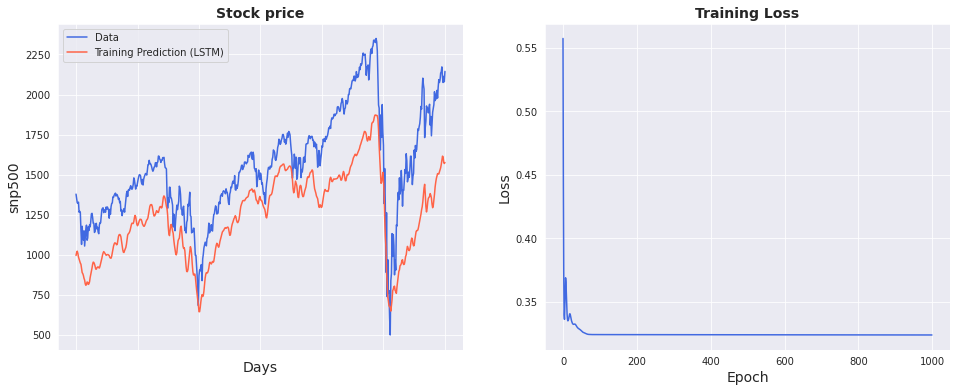

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("snp500", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [ ]:
def test_model(model, DEVICE):
    global testX
    with torch.no_grad():
        model.eval()
        for epoch in range(len(testX)):
            testX = testX.cuda()
            test_output = model(testX)




    return test_output

## Quantile loss - Test

In [ ]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
testX = testX.to(DEVICE)
testY = testY.to(DEVICE)
output_test = model(testX)

# calculate quantile loss 
trainScoreQuantile = quantile_loss(output, trainY.to(DEVICE), q, test=True)
print('Train Score: %.2f Quantile loss' % (trainScoreQuantile))
testScoreQuantile = quantile_loss(output_test, testY.to(DEVICE), q, test=True)
print('Test Score: %.2f Quantile loss' % (testScoreQuantile))

lstmQuantile = []
lstmQuantile.append(trainScoreQuantile)
lstmQuantile.append(testScoreQuantile)

Train Score: 0.32 Quantile loss
Test Score: 0.86 Quantile loss


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning:

nn.functional.tanh is deprecated. Use torch.tanh instead.



## RMSE - Test

In [ ]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
testX = testX.to(DEVICE)
testY = testY.to(DEVICE)
output_test = model(testX)

# invert predictions
y_train_pred = scaler.inverse_transform(output.cpu().detach().numpy())
y_train = scaler.inverse_transform(trainY.cpu().detach().numpy())
y_test_pred = scaler.inverse_transform(output_test.cpu().detach().numpy())
y_test = scaler.inverse_transform(testY.cpu().detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

lstm = []
lstm.append(trainScore)
lstm.append(testScore)

Train Score: 0.33 RMSE
Test Score: 2.44 RMSE


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning:

nn.functional.tanh is deprecated. Use torch.tanh instead.



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning:

nn.functional.tanh is deprecated. Use torch.tanh instead.



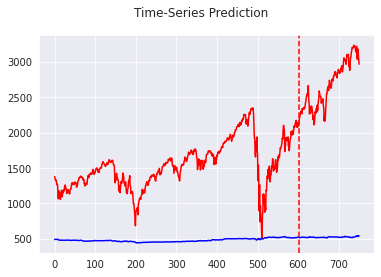

In [ ]:
model.eval()
dataX=dataX.to(DEVICE)
dataY=dataY.to(DEVICE)

train_predict = model(dataX)

data_predict = train_predict.data.cpu() 
dataY_plot = dataY.data.cpu() 

data_predict = scaler.inverse_transform(data_predict) * 1000
dataY_plot = scaler.inverse_transform(dataY_plot) * 1000

dataY_onlyprice=[]
for i in range(len(dataY_plot)):
     dataY_onlyprice.append(dataY_plot[i][0])

plt.axvline(x=train_size, c='r', linestyle='--')
plt.plot(dataY_onlyprice, 'r-')
plt.plot(data_predict, 'b-')
plt.suptitle('Time-Series Prediction')
plt.show()

# BackTesting

In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.3MB 6.4MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.62-py2.py3-none-any.whl size=23867 sha256=6305021477cfb412369151df3a91fe30863e86c3327b57ff11c2b8ea9c0fa9b5
  Stored in directory: /root/.cache/pip/wheels/38/5c/4a/7266ab5120deea4efa7a6dd8f6f41e913b77500ec3397c9f01
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
def get_positions(difference, thres=3, short=True):    
    if difference > thres/100:
        return 1
    elif short and difference < -thres/100:    
        return -1
    else:
        return 0

In [ ]:
# trading model의 DF dictionary
trade_df = {}

# Getting the percentage difference between the predictions and the actual values
trade_df['PercentDiff'] = (dataY_onlyprice / data_predict.flatten()) - 1

# Getting positions
getpos = lambda x: get_positions(x, 
                                 thres=1, 
                                 short=True)

vecfunc = np.vectorize(getpos)
trade_df['Positions'] = vecfunc(trade_df['PercentDiff'])

# Getting Log Returns
trade_df['LogReturns'] = logReturns.values

In [ ]:
# Calculating Returns by multiplying the 
# positions by the log returns
returns = trade_df['Positions'] * trade_df['LogReturns']

returns_df = pd.DataFrame({'returns':returns}) 

performance = returns_df.cumsum().apply(np.exp)

In [ ]:
import yfinance as yf # 저작작권 
import plotly.graph_objects as go

# Returns for the portfolio
returns_portf = (trade_df['Positions'] * trade_df['LogReturns'])

# Returns for SPY
spy = yf.download('SPY', start="2018-03-09", end="2021-03-05")

spy = spy['Close'].apply(np.log).diff().dropna().cumsum().apply(np.exp)
spy = pd.DataFrame({'returns':spy.values}) 

# Calculating the performance as we take the cumulative sum of the returns and transform the values back to normal
returns_df = pd.DataFrame({'returns':returns_portf}, index=np.arange(0, 751)) 
performance = returns_df.cumsum().apply(np.exp)

# Plotting the comparison between SPY returns and ARIMA returns
fig = go.Figure()

fig.add_trace(go.Scatter(x=spy.index,
                         y=spy.returns,
                         name='SPY Returns',
                         mode='lines'))

fig.add_trace(go.Scatter(x=performance.index,
                         y=performance.returns,
                         name='Quantile Regression on Portfolio',
                         mode='lines'))

fig.update_layout(title='SPY vs Quantile Regression Portfolio Returns',
                  xaxis_title='Date',
                  yaxis_title='Returns')

fig.show()

[*********************100%***********************]  1 of 1 completed


누적수익률 비교

In [ ]:
# compare cumulative returns between SPY VS Quntile
spy_cr_returns = spy.returns.sum()
performance_cr_returns = performance.returns.sum()

print('spy_cr_returns = ', spy_cr_returns)
print('performance_cr_returns = ', performance_cr_returns)

spy.returns[0] =  0.9987449130073359
performance.returns[0] =  0.9987260323623671
spy_cr_returns =  812.7557424962888
performance_cr_returns =  823.2347653979234


Sharpe Ratio

In [ ]:
daily_spy_returns = spy.returns.pct_change(1)
daily_perf_returns = performance.returns.pct_change(1)

spy_sharpe_ratio = np.mean(daily_spy_returns) / np.std(daily_spy_returns)
performance_sharpe_ratio = np.mean(daily_perf_returns) / np.std(daily_perf_returns)

print('spy_sharpe_ratio = ', spy_sharpe_ratio)
print('performance_sharpe_ratio = ', performance_sharpe_ratio)

spy_sharpe_ratio =  0.03526230302643303
performance_sharpe_ratio =  0.03774778740326644


# References
[1] https://m.blog.naver.com/sendmethere/221333164258  
[2] https://hipster4020.tistory.com/80  
[3] http://elearning.kocw.net/contents4/document/lec/2013/Konkuk/Leegiseong/9.pdf  
[4] https://www.youtube.com/watch?v=JPoXTzGgsYU  
[5] https://www.statology.org/f-test-python/. 
  
# Codes
[1] https://github.com/RodolfoLSS/stock-prediction-pytorch/blob/master/stock-prediction-pytorch.ipynb.   
**Quantile Loss**. 

[2] https://github.com/maxmarketit/Auto-PyTorch/blob/develop/examples/quantiles/Quantiles.ipynb.   

[3] https://github.com/ceshine/quantile-regression-tensorflow/blob/master/notebooks/03-sklearn-example-pytorch.ipynb.   

[4] https://www.kaggle.com/carlossouza/quantile-regression-pytorch-tabular-data-only